<a href="https://colab.research.google.com/github/svanderzeil/projects/blob/master/Climate_data1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Use seaborn for pairplot
!pip install seaborn


Climate data regression





In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


Check directory

In [0]:
import os
print (os.getcwd())

/content


Import the data from the CSV file and add the column headings

In [0]:
column_names = ['Soil Moisture Index', 'Maximum Temp',	'Rainfall','Evaporation']

raw_dataset = pd.read_csv('climate_data.csv', names=column_names,
                      na_values = "?", comment='\t',
                      skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.head()

,Soil Moisture Index,Maximum Temp,Rainfall,Evaporation
0,100.0,28.5,10.2,8.6
1,100.0,27.0,16.6,10.8
2,84.4,26.5,0.0,9.2
3,74.3,30.5,0.0,8.2
4,64.3,26.5,0.0,8.6


Check data

In [0]:
dataset.isna().sum()

Soil Moisture Index    0
Maximum Temp           0
Rainfall               0
Evaporation            0
dtype: int64

Split data into training and test sets

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Have a quick look at the joint distribution of a few pairs of columns from the training set.

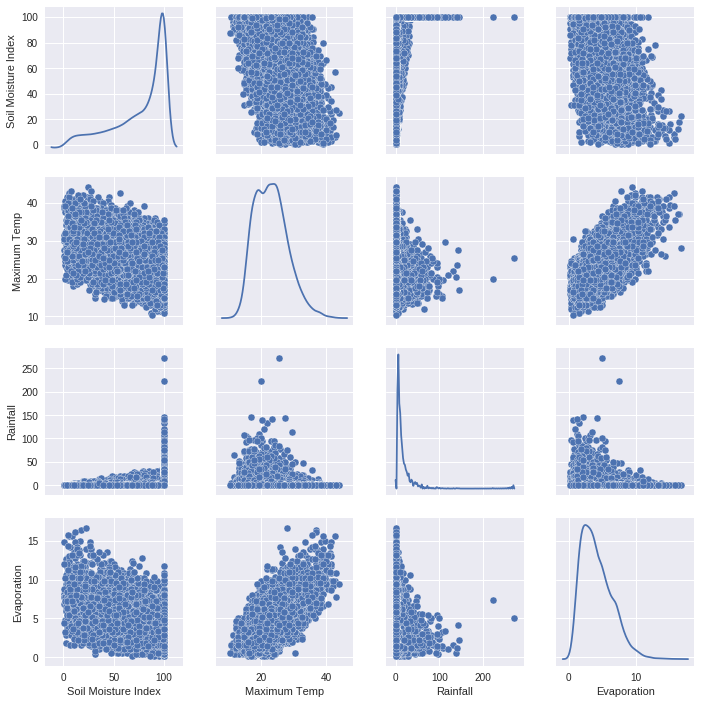

In [0]:
sns.pairplot(train_dataset[["Soil Moisture Index", "Maximum Temp",	"Rainfall","Evaporation"]], 
             diag_kind="kde")

Explore stats

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("Soil Moisture Index")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Maximum Temp,14190.0,23.192163,5.000454,10.5,19.5,23.0,26.500,44.0
Rainfall,14190.0,3.081071,9.387378,0.0,0.0,0.0,1.475,272.2
Evaporation,14190.0,4.184334,2.276288,0.2,2.4,3.8,5.600,16.6


Split value ('label')

In [0]:
train_labels = train_dataset.pop('Soil Moisture Index')
test_labels = test_dataset.pop('Soil Moisture Index')

Normalize the data (all inputs have to be normalized)

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Build the model, print model summary, set up PrintDot as monitoring and train model

In [0]:
model = tf.keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.RMSprop(0.001),
                metrics=['mean_absolute_error', 'mean_squared_error'])
model.summary()

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________

....................................................................................................

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
95,401.583229,14.960419,401.583282,399.536246,15.211959,399.536194,95
96,402.181500,14.971393,402.181458,402.335548,15.403834,402.335571,96
97,402.086016,14.973927,402.086151,404.577761,15.522977,404.577728,97
98,401.068210,14.951181,401.068329,404.934361,15.829098,404.934418,98
99,401.625859,14.975439,401.625671,401.743831,15.404269,401.743835,99


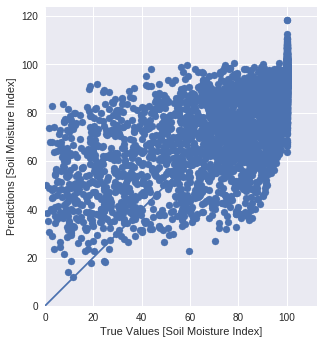

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Soil Moisture Index]')
plt.ylabel('Predictions [Soil Moisture Index]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])